In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_selected = pd.read_csv('data/rusentiment/rusentiment_preselected_posts.csv')
df_random = pd.read_csv('data/rusentiment/rusentiment_random_posts.csv')
df_test = pd.read_csv('data/rusentiment/rusentiment_test.csv')

In [3]:
print(f'Preselected length:{len(df_selected)}')
print(f'Random length:{len(df_random)}')
print(f'Test length:{len(df_test)}')

Preselected length:6950
Random length:21268
Test length:2967


In [4]:
df_selected['label'].value_counts()

neutral     2977
positive    1475
negative    1360
skip         904
speech       234
Name: label, dtype: int64

In [5]:
df_random['label'].value_counts()

neutral     8323
positive    4635
skip        3190
speech      2826
negative    2294
Name: label, dtype: int64

In [6]:
df_test['label'].value_counts()

neutral     1420
positive     536
speech       407
skip         346
negative     258
Name: label, dtype: int64

In [7]:
df_train = pd.concat((df_selected, df_random))

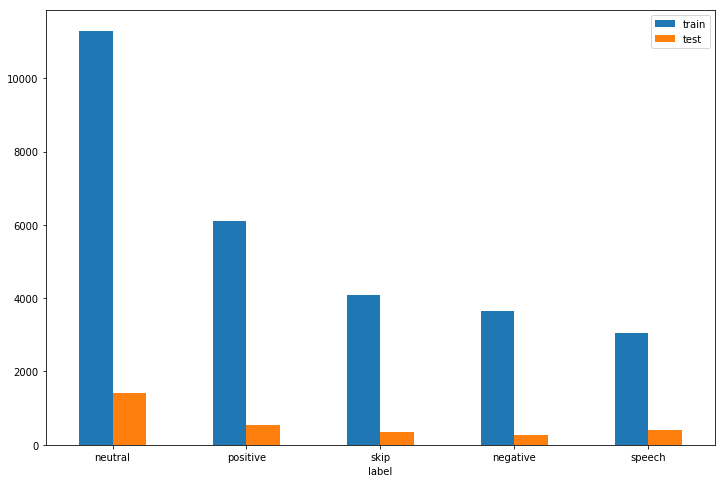

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'train': df_train.groupby('label').text.count(), 'test':df_test.groupby('label').text.count()})
freq.sort_values(by='train', ascending=False).plot.bar(rot=0, ax=ax);

In [9]:
# Original code https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py
from ufal.udpipe import Model, Pipeline

#! wget http://rusvectores.org/static/models/udpipe_syntagrus.model
udpipe_filename = 'udpipe_syntagrus.model'
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

def tag_ud(pipeline, text='Текст нужно передать функции в виде строки!', pos=True):
    # если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста лемму и тэг
    tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in content if w]

    tagged_propn = []
    propn = []
    for t in tagged:
        if t.endswith('PROPN'):
            if propn:
                propn.append(t)
            else:
                propn = [t]
        elif t.endswith('PUNCT'):
            propn = []
            continue  # я здесь пропускаю знаки препинания, но вы можете поступить по-другому
        else:
            if len(propn) > 1:
                name = '::'.join([x.split('_')[0] for x in propn]) + '_PROPN'
                tagged_propn.append(name)
            elif len(propn) == 1:
                tagged_propn.append(propn[0])
            tagged_propn.append(t)
            propn = []
    if not pos:
        tagged_propn = [t.split('_')[0] for t in tagged_propn]
    return tagged_propn

df_train['lemmatized_tokens'] = df_train.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)
df_test['lemmatized_tokens'] = df_test.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)

df_train.to_csv('data/rusentiment/train_lemmatized.csv', index=None)
df_test.to_csv('data/rusentiment/test_lemmatized.csv', index=None)

In [10]:
df_train['lemmatized_text'] = df_train['lemmatized_tokens'].str.join(' ')
df_test['lemmatized_text'] = df_test['lemmatized_tokens'].str.join(' ')

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_train = df_train['lemmatized_text'].values
X_test = df_test['lemmatized_text'].values

y_train  = le.fit_transform(df_train['label'].values)
y_test  = le.transform(df_test['label'].values) 

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import expon

# svc_pipeline = Pipeline([('tfidf',TfidfVectorizer()), ('svc', LinearSVC(penalty='l1', dual=False))])

# C_distr = expon(scale=2)
# param_grid = {'tfidf__ngram_range':[(1,1),(1,2)],
#               'tfidf__sublinear_tf':[True, False],
#               'svc__C': C_distr}

# skf = StratifiedKFold(n_splits=5, random_state=42)

# grid = RandomizedSearchCV(svc_pipeline, param_grid, n_iter=100, scoring='f1_macro', cv=skf)
# grid_model = grid.fit(X_train, y_train)
# grid_model.best_params_

best_svc_pipeline = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,1), sublinear_tf=False)),
                              ('svc', LinearSVC(C=0.6235, penalty='l1', dual=False))])

best_svc_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0))])

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

y_pred = best_svc_pipeline.predict(X_test)
def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

Precision: 0.6660
Recall: 0.6812
f1-score: 0.6616


/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


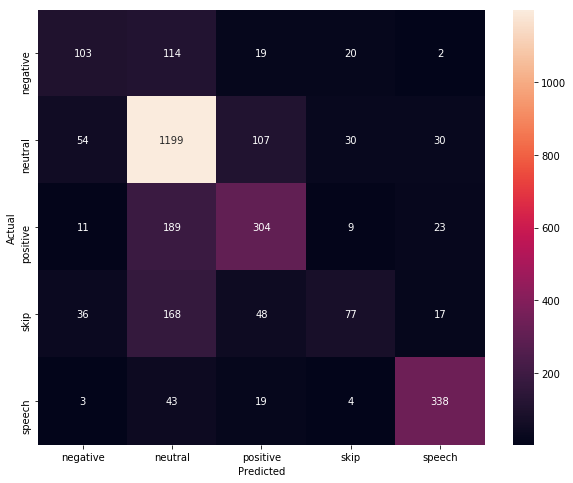

In [16]:
from sklearn.metrics import confusion_matrix
y_pred
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(y_pred))))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()